In [1]:
import tensorflow as tf
import os
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import pickle
import time
import pywt
from MMD_metric import _mix_rbf_kernel, mix_rbf_mmd2, _mmd2
from CCF import CCF

# set the tensorflow verbosity
tf.logging.set_verbosity(tf.logging.DEBUG)

C:\Users\user\anaconda3\envs\tf_1.14\lib\site-packages\tensorflow\python\framework\dtypes.py:516: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
C:\Users\user\anaconda3\envs\tf_1.14\lib\site-packages\tensorflow\python\framework\dtypes.py:517: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
C:\Users\user\anaconda3\envs\tf_1.14\lib\site-packages\tensorflow\python\framework\dtypes.py:518: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
C:\Users\user\anaconda3\envs\tf_1.14\lib\site-packages\tensorflow\pyth

In [2]:

#################################### GAN ########################################

############# data path #############
data_index = "d11_te.dat"
data_folder = "tennessee-eastman-profBraatz-master/"
data_path = data_folder + data_index

data_test_index = "d11.dat"
data_test_path = data_folder + data_test_index

############# folder path #############
index = 'tep11'

folder = "TEP_WGAN_BP_" + index + "_wavelet/"
gen_results = 'generated_results/'
gen_data = 'gen_data_'

model_ = 'model_gan_' + index
model = model_+'.ckpt' 

if not os.path.isdir(folder):
    os.mkdir(folder)
    
if not os.path.isdir(folder + gen_results):
    os.mkdir(folder + gen_results)

saver_path = os.path.join(folder, model)
restore_path = os.path.join(folder)
generated_path = os.path.join(folder + gen_results)

#################################### AE ########################################
folder_AE = 'AE_BP_' + index + '_CCF_final/'
restore_path_AE = os.path.join(folder_AE)

In [4]:
def add_window_(time_series, time_step, multiply):
    
    series_window_multiply = []
    L = len(time_series)

    for i in range(L-time_step):
        dat = time_series[i:i+time_step]
        for j in range(multiply):
            series_window_multiply.append(dat)
    
    series_window_multiply = np.array(series_window_multiply)
    
    return series_window_multiply

In [5]:
def wavelelt_decompose(x, level_num, invariant_num):  # x:(26, 250, 52)

    if invariant_num == 1: 
        tep_high_fre = []
        final_window_CA = []
        high_fre_len = []

        for i in range(len(x)): #batch_num
            high_fre_within_batch = []
            for j in range(x.shape[-1]): #var_num
                coeffs = pywt.wavedec(x[i,:,j], 'db1', level=level_num, mode='sym')
    #             ca3, cd3, cd2, cd1 = coeffs
                high_fre_within_var = coeffs[-1]
                for k in range( len(coeffs) - (invariant_num+1) ): #4-2
                    high_fre_within_var = np.concatenate((high_fre_within_var, coeffs[-(k+2)]), axis=0)
                high_fre_within_batch.append(high_fre_within_var)

                if i == (len(x)-1):  
                    final_window_CA.append(coeffs[invariant_num-1])                      
            tep_high_fre.append(high_fre_within_batch) 
            
        for n in range( len(coeffs) - (invariant_num) ): #4-1
            high_fre_len.append(len(coeffs[-(n+1)]))
            
        tep_high_fre = np.array(tep_high_fre)
        final_window_CA = np.array(final_window_CA)
        
        return tep_high_fre, final_window_CA, high_fre_len 

###################################################################################################    
    
    if invariant_num == 2:
        tep_high_fre = []
        final_window_CA = []
        final_window_CD = []    
        high_fre_len = []
        
        for i in range(len(x)): #batch_num
            high_fre_within_batch = []
            for j in range(x.shape[-1]): #var_num
                coeffs = pywt.wavedec(x[i,:,j], 'db1', level=level_num, mode='sym')
    #             ca3, cd3, cd2, cd1 = coeffs
                high_fre_within_var = coeffs[-1]
                for k in range( len(coeffs) - (invariant_num+1) ): #4-3
                    high_fre_within_var = np.concatenate((high_fre_within_var, coeffs[-(k+2)]), axis=0)
                high_fre_within_batch.append(high_fre_within_var)

                if i == (len(x)-1): 
                    final_window_CA.append(coeffs[invariant_num-2])
                    final_window_CD.append(coeffs[invariant_num-1])
                    
            tep_high_fre.append(high_fre_within_batch) 
            
        for n in range( len(coeffs) - (invariant_num) ):
            high_fre_len.append(len(coeffs[-(n+1)]))            

        tep_high_fre = np.array(tep_high_fre)
        final_window_CA = np.array(final_window_CA)
        final_window_CD = np.array(final_window_CD)
        
        return tep_high_fre, final_window_CA, final_window_CD, high_fre_len

In [6]:
def normalize_fre(x):  #x:(26, 52, 244) = (batch_num, vars_num, high_fre_len)
    tep_high_fre_norm = []

    for i in range(len(x)):
        data_mean = np.mean(x[0,:,:],-1).reshape(1,-1) 
        data_std = np.std(x[0,:,:],-1,ddof=1).reshape(1,-1) 
        temp = (x[i,:,:].T - data_mean)/data_std

        tep_high_fre_norm.append(temp)

    tep_high_fre_norm = np.array(tep_high_fre_norm).transpose((0,2,1))
    
    return tep_high_fre_norm, data_mean, data_std

In [7]:
def add_window_multiply(time_series, time_step, multiply):
    
    series_window_multiply = []
    L = len(time_series)

    start = 0
    end = 0
    for i in range(L//time_step):
        end = end+time_step
        dat = time_series[start:end]
        for j in range(multiply):
            series_window_multiply.append(dat)
        start = end
    
    series_window_multiply = np.array(series_window_multiply)
    
    return series_window_multiply

# ----------------------data part-------------------------

# load data

In [8]:
dat = np.genfromtxt(data_path)
tep_data_ori = dat[:]  #300:800
tep_data_ori_part = dat[-180:]  #300:800
tep_data = dat[-180:]      #300:800
print(tep_data.shape)

(180, 52)


In [9]:
# load test data
tep_test_data = np.genfromtxt(data_test_path)
print(tep_test_data.shape)

(480, 52)


# ENCODE THE DATA - start

In [11]:
data_mean = np.mean(tep_data,0)   #(72,)
data_std = np.std(tep_data,0,ddof=1) 
tep_data = (tep_data - data_mean)/data_std

print(tep_data.shape)

(180, 52)


In [12]:
tep_data_pd = pd.DataFrame(tep_data)
CCFtrain=CCF(tep_data_pd,maxlag=0)
CCFtrain.cal()
tep_data_matrix = CCFtrain.get_matrix()

In [13]:
tep_data_matrix = np.array(tep_data_matrix)
ccf_value = 0.5

temp = 0
for i in range(len(tep_data_matrix)):
    for j in range(len(tep_data_matrix)):
        if tep_data_matrix[i,j] >= ccf_value:
            temp = temp + 1
dim_ccf = int((temp-52)/2)
dim_ccf_ratio = dim_ccf/((51+1)*51/2)



27
0.020361990950226245


In [14]:
nsteps_gan = 1 
multiply = 1  

tep_data_win = add_window_multiply(tep_data, nsteps_gan, multiply)
print("tep_data_win shape:",tep_data_win.shape)

tep_data_win shape: (180, 1, 52)


In [15]:
# training parameters
dim_input_AE = tep_data_win.shape[-1] 
timestep_AE = tep_data_win.shape[1]
dim_z_AE = int(dim_input_AE*(1-dim_ccf_ratio))
print(dim_z_AE)

50


In [16]:
def bp_encoder_trained(X):
        
    with graph_AE.as_default():
    
        batch_size_feed = len(tep_data_win)
        keep_prob_feed = 1

        X_in = tf.reshape(X, (batch_size_feed, timestep_AE, dim_input_AE))

        with tf.variable_scope("bp_encoder", reuse = tf.AUTO_REUSE):

            hidden = tf.layers.dense(X_in, units = 256, activation=tf.nn.relu) 
            hidden = tf.layers.dropout(hidden, rate = 1-keep_prob_feed)  

            hidden = tf.layers.dense(hidden, units = 512, activation=tf.nn.relu)
            hidden = tf.layers.dropout(hidden, rate = 1-keep_prob_feed)

            hidden = tf.layers.dense(hidden, units = dim_z_AE)
            hidden = tf.layers.dropout(hidden, rate = 1-keep_prob_feed)  

            z = tf.reshape(hidden, (batch_size_feed, timestep_AE, dim_z_AE))
                
    return z

In [17]:
graph_AE = tf.Graph()
with graph_AE.as_default():
    
    X_AE = tf.placeholder(tf.float32, shape=(None, timestep_AE, dim_input_AE))
    Z_AE = tf.placeholder(tf.float32, shape=(None, timestep_AE, dim_z_AE))   
    
    tep_encode = bp_encoder_trained(X_AE) 
    
    saver_encode = tf.train.Saver()

    gpu_options = tf.GPUOptions(allow_growth=True)
    with tf.Session(config=tf.ConfigProto(gpu_options=gpu_options), graph = graph_AE) as sess:
        saver_encode.restore(sess, tf.train.latest_checkpoint(restore_path_AE))    

        input_data = tep_data_win
        tep_encode_ = sess.run([tep_encode], feed_dict={X_AE: input_data})
        sess.close()
    
tep_data_encode = np.array(tep_encode_).reshape((-1, dim_z_AE))  
print(tep_data_encode.shape)
print(dim_z_AE)

Instructions for updating:
Use keras.layers.dense instead.
Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor
Instructions for updating:
Use keras.layers.dropout instead.
Instructions for updating:
Use standard file APIs to check for files with this prefix.
INFO:tensorflow:Restoring parameters from AE_BP_tep11_CCF_final/model_tep11.ckpt
(180, 50)
50


# ENCODE THE DATA - end

In [18]:
'''add window'''
window_size = 60
window_Step = 1
tep_data_win = add_window_(tep_data_encode, window_size, window_Step)
print(tep_data_win.shape)

(120, 60, 50)


In [19]:
'''wavelet parameter'''
level_num = 5 #6、2
invariant_num = 2

In [20]:
'''wavelet decompose
CA: lowest fre msg
CD: second lowest fre msg
'''
########################## '''keep CA、CD''' ##########################
if invariant_num == 2:  
    tep_high_fre, final_window_CA, final_window_CD, high_fre_len = wavelelt_decompose(tep_data_win, level_num, invariant_num)

########################## '''keep CA''' ##########################
if invariant_num == 1:  
    tep_high_fre, final_window_CA, high_fre_len = wavelelt_decompose(tep_data_win, level_num, invariant_num)

保留CA、CD
(batch_size, num_vars, len(高頻)): (120, 50, 57)
用來recover的CA: (50, 2)
用來recover的CD: (50, 2)
高頻分量長度: [30, 15, 8, 4]
57


In [21]:
# shuffle
np.random.seed(0)
np.random.shuffle(tep_high_fre)
print(tep_high_fre.shape)

(120, 50, 57)


# ----------------------parameter-------------------------

In [22]:
# training parameters
batch_size = 1

dim_input = tep_high_fre.shape[-1]  
num_vars = tep_high_fre.shape[1]  
dim_z = dim_input//2  

# ----------------------fuction part-------------------------

In [23]:
def show_train_hist(hist, show = False, save = False, path = 'Train_hist.png'):
    x = range(len(hist['D_losses']))

    y1 = hist['D_losses']
    y2 = hist['G_losses']

    plt.plot(x, y1, label='D_loss')
    plt.plot(x, y2, label='G_loss')

    plt.xlabel('Epoch')
    plt.ylabel('Loss')

    plt.legend(loc=4) 
    plt.grid(True)
    plt.tight_layout() 
    plt.title("Training Losses")
    
    if save:
        plt.savefig(path)

    if show:
        plt.show()
    else:
        plt.close()

# ----------------------model part-------------------------

In [24]:
def generator(Z, keep_prob_feed): 
    
    with graph_gan.as_default():
    
        Z_in = tf.reshape(Z, (batch_size, num_vars, dim_z))

        with tf.variable_scope("GEN", reuse = tf.AUTO_REUSE):

            hidden = tf.layers.dense(Z_in, units = 128, activation=tf.nn.relu) 
            hidden = tf.layers.dropout(hidden, rate = 1-keep_prob_feed)

            hidden = tf.layers.dense(hidden, units = 64, activation=tf.nn.relu)
            hidden = tf.layers.dropout(hidden, rate = 1-keep_prob_feed) 

            hidden = tf.layers.dense(hidden, units = dim_input)
            hidden = tf.layers.dropout(hidden, rate = 1-keep_prob_feed)

            gen_outputs = tf.reshape(hidden, (batch_size, num_vars, dim_input))

    return gen_outputs

In [25]:
def discriminator(X, keep_prob_feed):
    
    with graph_gan.as_default():
    
        X_in = tf.reshape(X, (batch_size, num_vars, dim_input))

        with tf.variable_scope("DIS", reuse = tf.AUTO_REUSE):

            hidden = tf.layers.dense(X_in, units = 128, activation=tf.nn.relu) 
            hidden = tf.layers.dropout(hidden, rate = 1-keep_prob_feed)

            hidden = tf.layers.dense(hidden, units = 128, activation=tf.nn.relu)
            hidden = tf.layers.dropout(hidden, rate = 1-keep_prob_feed)

            hidden = tf.layers.dense(hidden, units = 64)
            hidden = tf.layers.dropout(hidden, rate = 1-keep_prob_feed)

            hidden = tf.layers.dense(hidden, units = 1)        
            score = tf.reshape(hidden, (-1, 1))  

    return score

In [26]:
# define a graph for GAN
graph_gan = tf.Graph()
with graph_gan.as_default():

    # variables : input
    X = tf.placeholder(tf.float32, shape=(None, num_vars, dim_input))
    Z = tf.placeholder(tf.float32, shape=(None, num_vars, dim_z))
    keep_prob_feed = tf.placeholder(tf.float32)
    global_step = tf.Variable(0, trainable = False)

    # networks : generator
    fake_output = generator(Z, keep_prob_feed)

    # networks : discriminator
    real_score = discriminator(X, keep_prob_feed)
    fake_score = discriminator(fake_output, keep_prob_feed)

    # define the loss ops
    D_loss = tf.reduce_mean(-real_score + fake_score)
    G_loss = tf.reduce_mean(-fake_score)

    # define the optimizer ops
    T_vars = tf.trainable_variables()
    D_vars = [var for var in T_vars if var.name.startswith('DIS')]
    G_vars = [var for var in T_vars if var.name.startswith('GEN')]

    lr = 0.001
    decay_rate = 0.85
    decay_step = 400
    learning_rate_decayed = lr*decay_rate**(global_step/decay_step)

    # update_ops = tf.get_collection(tf.GraphKeys.UPDATE_OPS)
    # with tf.control_dependencies(update_ops):
    D_optimizer = tf.train.RMSPropOptimizer(learning_rate_decayed).minimize(D_loss, var_list=D_vars)
    G_optimizer = tf.train.RMSPropOptimizer(learning_rate_decayed).minimize(G_loss, var_list=G_vars)

Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor


In [27]:
train_epoch = 800
keep_prob = 0.1
n_critic = 6

# save loss
train_hist = {}
train_hist['D_losses'] = []
train_hist['G_losses'] = []

with graph_gan.as_default():

    saver = tf.train.Saver()

    session_config = tf.ConfigProto(gpu_options = tf.GPUOptions(allow_growth=True))
    with tf.Session(config = session_config, graph = graph_gan) as sess:
        sess.run(tf.global_variables_initializer())

        print('Optimization start!')
        start = time.time()

        for epoch in range(train_epoch):  
            G_losses = []
            D_losses = []

            for i in range(len(tep_high_fre) // batch_size): # tep_high_fre: (batch_size, num_vars, len=diminput)
                '''#############         Discriminator       #######################'''
                real_data = tep_high_fre[i * batch_size: (i + 1) * batch_size] #(batch_size)
                real_data = real_data.reshape((batch_size, num_vars, dim_input))    #(batch_size, num_vars, diminput)

                noise_D = np.random.normal(0, 1, (batch_size, num_vars, dim_z))     #(batch_size*time_step, dim_z)

                _, loss_d_, _ = sess.run([D_optimizer, D_loss, clipping_op], 
                             feed_dict={X: real_data,             
                                        Z: noise_D,                
                                        keep_prob_feed: keep_prob,
                                        global_step: epoch
                                       })

                D_losses.append(loss_d_)


                '''#############         Generator          #######################'''
                if i % n_critic == 0:   # Train the generator every n_critic iterations
                    noise_G = np.random.normal(0, 1, (batch_size, num_vars, dim_z))  #(batch_size*time_step, dim_z)    

                    _, loss_g_ = sess.run([G_optimizer, G_loss], 
                                 feed_dict={Z: noise_G,              
                                            keep_prob_feed: keep_prob,
                                            global_step: epoch
                                           })
                    G_losses.append(loss_g_)


        ############        show result      #######################
            print('[%d/%d] loss_d: %.3f, loss_g: %.3f'%((epoch + 1), train_epoch, np.mean(D_losses), np.mean(G_losses)))
            train_hist['D_losses'].append(np.mean(D_losses))
            train_hist['G_losses'].append(np.mean(G_losses))

            #############        save model      #######################
            saver.save(sess, saver_path)   

        sess.close()
    
print("Optimization Finished!")
end = time.time()
print("runtime：%f 秒" % (end - start))

Optimization start!
[1/800] loss_d: 0.000, loss_g: -0.000
[2/800] loss_d: -0.013, loss_g: 0.003
[3/800] loss_d: -0.029, loss_g: 0.006
[4/800] loss_d: -0.031, loss_g: 0.006
[5/800] loss_d: -0.030, loss_g: 0.006
[6/800] loss_d: -0.030, loss_g: 0.005
[7/800] loss_d: -0.026, loss_g: 0.002
[8/800] loss_d: -0.017, loss_g: -0.005
[9/800] loss_d: -0.019, loss_g: -0.007
[10/800] loss_d: -0.018, loss_g: -0.009
[11/800] loss_d: -0.017, loss_g: -0.009
[12/800] loss_d: -0.016, loss_g: -0.010
[13/800] loss_d: -0.015, loss_g: -0.010
[14/800] loss_d: -0.015, loss_g: -0.010
[15/800] loss_d: -0.014, loss_g: -0.010
[16/800] loss_d: -0.014, loss_g: -0.010
[17/800] loss_d: -0.014, loss_g: -0.010
[18/800] loss_d: -0.013, loss_g: -0.010
[19/800] loss_d: -0.013, loss_g: -0.010
[20/800] loss_d: -0.013, loss_g: -0.010
[21/800] loss_d: -0.012, loss_g: -0.011
[22/800] loss_d: -0.012, loss_g: -0.010
[23/800] loss_d: -0.011, loss_g: -0.011
[24/800] loss_d: -0.011, loss_g: -0.011
[25/800] loss_d: -0.011, loss_g: -0.

[204/800] loss_d: -0.000, loss_g: -0.005
[205/800] loss_d: -0.000, loss_g: -0.004
[206/800] loss_d: -0.000, loss_g: -0.004
[207/800] loss_d: -0.000, loss_g: -0.006
[208/800] loss_d: -0.000, loss_g: -0.005
[209/800] loss_d: -0.000, loss_g: -0.006
[210/800] loss_d: -0.000, loss_g: -0.007
[211/800] loss_d: -0.000, loss_g: -0.006
[212/800] loss_d: -0.000, loss_g: -0.005
[213/800] loss_d: -0.000, loss_g: -0.006
[214/800] loss_d: -0.000, loss_g: -0.006
[215/800] loss_d: -0.000, loss_g: -0.006
[216/800] loss_d: -0.000, loss_g: -0.006
[217/800] loss_d: -0.000, loss_g: -0.004
[218/800] loss_d: -0.000, loss_g: -0.004
[219/800] loss_d: -0.000, loss_g: -0.005
[220/800] loss_d: -0.000, loss_g: -0.006
[221/800] loss_d: -0.000, loss_g: -0.006
[222/800] loss_d: -0.000, loss_g: -0.005
[223/800] loss_d: -0.000, loss_g: -0.005
[224/800] loss_d: -0.000, loss_g: -0.006
[225/800] loss_d: -0.000, loss_g: -0.006
[226/800] loss_d: -0.000, loss_g: -0.006
[227/800] loss_d: -0.000, loss_g: -0.004
[228/800] loss_d

[404/800] loss_d: -0.000, loss_g: -0.006
[405/800] loss_d: -0.000, loss_g: -0.006
[406/800] loss_d: -0.001, loss_g: -0.007
[407/800] loss_d: -0.000, loss_g: -0.007
[408/800] loss_d: -0.001, loss_g: -0.007
[409/800] loss_d: -0.000, loss_g: -0.007
[410/800] loss_d: -0.000, loss_g: -0.006
[411/800] loss_d: -0.000, loss_g: -0.006
[412/800] loss_d: -0.000, loss_g: -0.007
[413/800] loss_d: -0.000, loss_g: -0.006
[414/800] loss_d: -0.001, loss_g: -0.007
[415/800] loss_d: -0.001, loss_g: -0.007
[416/800] loss_d: -0.001, loss_g: -0.007
[417/800] loss_d: -0.000, loss_g: -0.006
[418/800] loss_d: -0.001, loss_g: -0.007
[419/800] loss_d: -0.000, loss_g: -0.006
[420/800] loss_d: -0.000, loss_g: -0.006
[421/800] loss_d: -0.000, loss_g: -0.006
[422/800] loss_d: -0.000, loss_g: -0.007
[423/800] loss_d: -0.000, loss_g: -0.005
[424/800] loss_d: -0.000, loss_g: -0.007
[425/800] loss_d: -0.000, loss_g: -0.006
[426/800] loss_d: -0.000, loss_g: -0.007
[427/800] loss_d: -0.000, loss_g: -0.006
[428/800] loss_d

[604/800] loss_d: -0.000, loss_g: -0.006
[605/800] loss_d: -0.000, loss_g: -0.007
[606/800] loss_d: -0.000, loss_g: -0.006
[607/800] loss_d: -0.000, loss_g: -0.005
[608/800] loss_d: -0.000, loss_g: -0.006
[609/800] loss_d: -0.000, loss_g: -0.007
[610/800] loss_d: -0.000, loss_g: -0.005
[611/800] loss_d: -0.000, loss_g: -0.004
[612/800] loss_d: -0.000, loss_g: -0.004
[613/800] loss_d: -0.000, loss_g: -0.004
[614/800] loss_d: -0.000, loss_g: -0.004
[615/800] loss_d: -0.000, loss_g: -0.005
[616/800] loss_d: -0.000, loss_g: -0.006
[617/800] loss_d: -0.000, loss_g: -0.006
[618/800] loss_d: -0.000, loss_g: -0.006
[619/800] loss_d: -0.000, loss_g: -0.006
[620/800] loss_d: -0.000, loss_g: -0.007
[621/800] loss_d: -0.000, loss_g: -0.007
[622/800] loss_d: -0.000, loss_g: -0.005
[623/800] loss_d: -0.000, loss_g: -0.006
[624/800] loss_d: -0.000, loss_g: -0.007
[625/800] loss_d: -0.000, loss_g: -0.006
[626/800] loss_d: -0.000, loss_g: -0.005
[627/800] loss_d: -0.000, loss_g: -0.007
[628/800] loss_d

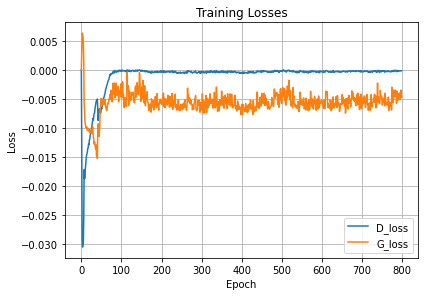

In [28]:
with open(folder + 'train_hist.pkl', 'wb') as f:
    pickle.dump(train_hist, f)
    
save_loss_path = folder + 'train_hist.png'  

show_train_hist(train_hist, show = True,save=True, path=save_loss_path)

In [29]:
def generator_test(Z, keep_prob_feed): 
    
    with graph_gan.as_default():
    
        Z_in = tf.reshape(Z, (batch_size, num_vars, dim_z))

        with tf.variable_scope("GEN", reuse = tf.AUTO_REUSE):

            hidden = tf.layers.dense(Z_in, units = 128, activation=tf.nn.relu)
            hidden = tf.layers.dropout(hidden, rate = 1-keep_prob_feed)

            hidden = tf.layers.dense(hidden, units = 64, activation=tf.nn.relu)
            hidden = tf.layers.dropout(hidden, rate = 1-keep_prob_feed) 

            hidden = tf.layers.dense(hidden, units = dim_input)
            hidden = tf.layers.dropout(hidden, rate = 1-keep_prob_feed)

            gen_outputs = tf.reshape(hidden, (batch_size, num_vars, dim_input))

    return gen_outputs

In [30]:
# define test model
with graph_gan.as_default():
    
    fake_output_test = generator_test(Z, keep_prob_feed) 

    saver = tf.train.Saver()

    test_epoch = 1
    gpu_options = tf.GPUOptions(allow_growth=True)
    with tf.Session(config=tf.ConfigProto(gpu_options=gpu_options), graph = graph_gan) as sess:
        saver.restore(sess, tf.train.latest_checkpoint(restore_path))    

        for i in range(test_epoch):
            noise_G = np.random.normal(0, 1, (batch_size, num_vars, dim_z))  

            generator_output = sess.run([fake_output_test], 
                           feed_dict={Z: noise_G,  
                                    keep_prob_feed: 1,
                                    global_step: 0
                                     })

            generator_output = np.array(generator_output)                #(batch_size, timestep, diminput)
            generator_output = generator_output.reshape((-1, dim_input))  #(batch_size*timestep, diminput) 

        print(generator_output.shape)
        sess.close()

INFO:tensorflow:Restoring parameters from TEP_WGAN_BP_tep11_wavelet/model_gan_tep11.ckpt
(50, 57)


# Recover the sign

In [31]:
def recover_wavelet_invariant_num_2(generator_output, high_fre_len, final_window_CA, final_window_CD, num_vars):
    recover_output = []

    for i in range(num_vars):
        coeffs_new = []

        coeffs_new.append(final_window_CA[i,:])
        coeffs_new.append(final_window_CD[i,:])

        temp = generator_output[i,:]
        for j in range(len(high_fre_len)):
            coeffs_new.append( temp[-(high_fre_len[-(j+1)]):] )
            temp = list(temp)
            del temp[ -(high_fre_len[-(j+1)]): ]
            temp = np.array(temp)

        var_recover = pywt.waverec(coeffs_new, 'db1', mode='sym')
        recover_output.append(var_recover)

    recover_output = np.array(recover_output) 
    recover_output = recover_output.T
    
    return recover_output

In [32]:
def recover_wavelet_invariant_num_1(generator_output, high_fre_len, final_window_CA, num_vars):
    recover_output = []
    
    for i in range(num_vars):
        coeffs_new = []

        coeffs_new.append(final_window_CA[i,:])
        
        temp = generator_output[i,:]
        for j in range(len(high_fre_len)):
            coeffs_new.append(temp[ -(high_fre_len[-(j+1)]): ])
            temp = list(temp)
            del temp[ -(high_fre_len[-(j+1)]): ]
            temp = np.array(temp)
        
        var_recover = pywt.waverec(coeffs_new, 'db1', mode='sym')
        recover_output.append(var_recover)
        
    recover_output = np.array(recover_output) 
    recover_output = recover_output.T
    
    return recover_output

In [33]:
if invariant_num == 2:  
    gen_output = recover_wavelet_invariant_num_2(generator_output, high_fre_len, final_window_CA, final_window_CD, num_vars)

if invariant_num == 1:  
    gen_output = recover_wavelet_invariant_num_1(generator_output, high_fre_len, final_window_CA, num_vars)

保留CA、CD
(60, 50)


In [34]:
def bp_decoder_trained(Z):
    
    with graph_AE.as_default():

        batch_size_feed = len(gen_output)
        keep_prob_feed = 1

        Z_in = tf.reshape(Z, (batch_size_feed, timestep_AE, dim_z_AE))

        with tf.variable_scope("bp_decoder", reuse = tf.AUTO_REUSE):

            hidden = tf.layers.dense(Z_in, units = 512, activation=tf.nn.relu)
            hidden = tf.layers.dropout(hidden, rate = 1-keep_prob_feed) 

            hidden = tf.layers.dense(hidden, units = 256, activation=tf.nn.relu)
            hidden = tf.layers.dropout(hidden, rate = 1-keep_prob_feed) 

            hidden = tf.layers.dense(hidden, units = dim_input_AE)
            hidden = tf.layers.dropout(hidden, rate = 1-keep_prob_feed)

            gen_outputs = tf.reshape(hidden, (batch_size_feed, timestep_AE, dim_input_AE))

    return gen_outputs


In [35]:
with graph_AE.as_default():

    tep_decode = bp_decoder_trained(Z_AE) 

    saver = tf.train.Saver()

    gpu_options = tf.GPUOptions(allow_growth=True)
    with tf.Session(config=tf.ConfigProto(gpu_options=gpu_options), graph = graph_AE) as sess:
        saver.restore(sess, tf.train.latest_checkpoint(restore_path_AE))

        input_data = gen_output.reshape((-1, timestep_AE, dim_z_AE))

        tep_decode_ = sess.run([tep_decode], 
                       feed_dict={Z_AE: input_data})

        sess.close()
    
tep_data_decode = np.array(tep_decode_).reshape((-1, dim_input_AE))  #(batch_size*timestep, diminput)
tep_data_decode = (tep_data_decode*data_std) + data_mean
print(tep_data_decode.shape)
gen_output = tep_data_decode

INFO:tensorflow:Restoring parameters from AE_BP_tep11_CCF_final/model_tep11.ckpt
(60, 52)


# save the generated data

In [36]:
def save_result(x, save = False, path='TEP_GAN_4_results_new/Fixed_results'): 
        
    if save:
        df = pd.DataFrame(x)
        df.to_csv(path)

In [37]:
gen_save_path = folder + gen_results + gen_data + index + '.csv'  
save_result(gen_output, save=True, path = gen_save_path)  

# MMD_distacne

In [38]:
def MMD_distance(generated_data, real_data): #
    generated_data = generated_data.astype(np.float32)
    print("generated_data.shape:", generated_data.shape)

    real_data = real_data.astype(np.float32)
    print("real_data.shape:", real_data.shape)
    
    session_config = tf.ConfigProto(gpu_options = tf.GPUOptions(allow_growth=True))
    with tf.Session(config = session_config) as sess:    
        sess.run(tf.global_variables_initializer())

        bandwidths = [2.0, 5.0, 10.0, 20.0, 40.0, 80.0]  
        mmd_loss,t1,t2,t3 = mix_rbf_mmd2(generated_data, real_data, sigmas=bandwidths)
        mmd_loss_,t1_,t2_,t3_ = sess.run([mmd_loss,t1,t2,t3])
        print("generated_output vs real_data:", mmd_loss_)
        sess.close()

In [39]:
print('-------train v.s generated-------')
MMD_distance(gen_output, tep_data_ori_part[:120])
print('\n')
print('-------train v.s test-------')
MMD_distance(tep_data_ori_part[120:], tep_data_ori_part[:120])

-------train v.s generated-------
generated_data.shape: (60, 52)
real_data.shape: (120, 52)

generated_output vs real_data: 0.18441153


-------train v.s test-------
generated_data.shape: (60, 52)
real_data.shape: (120, 52)
generated_output vs real_data: 0.11606407


C:\Users\user\AppData\Roaming\Python\Python37\site-packages\ipykernel_launcher.py:2: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  


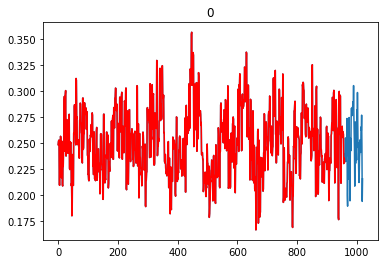

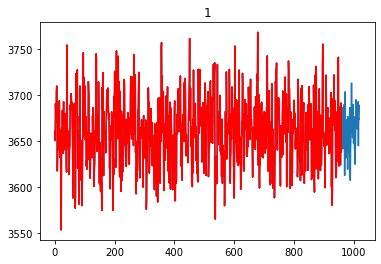

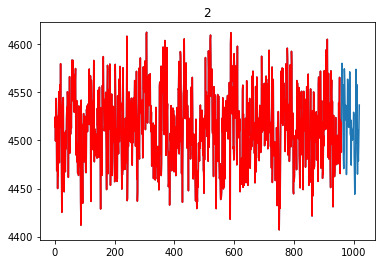

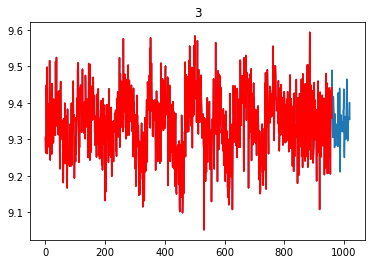

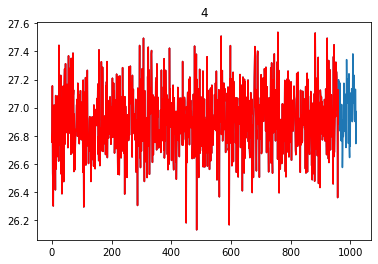

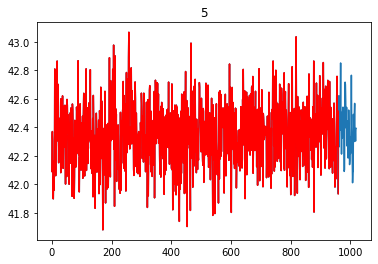

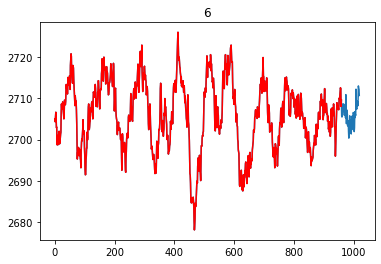

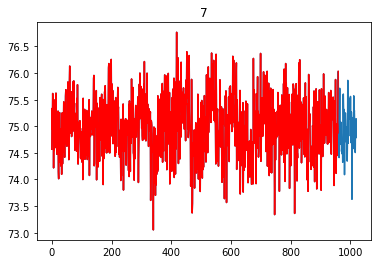

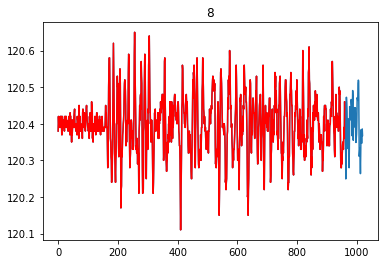

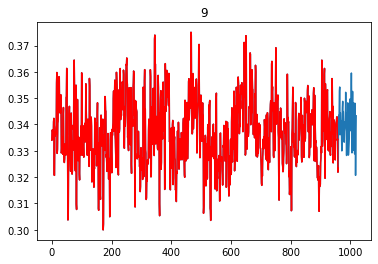

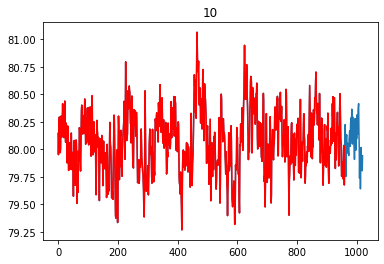

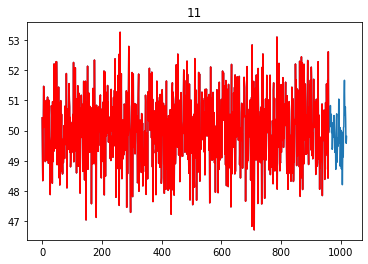

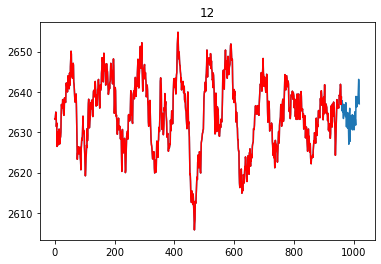

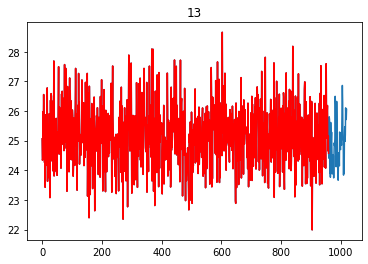

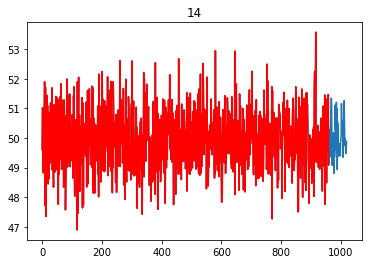

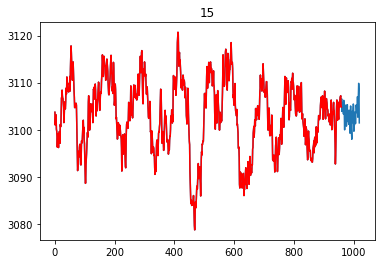

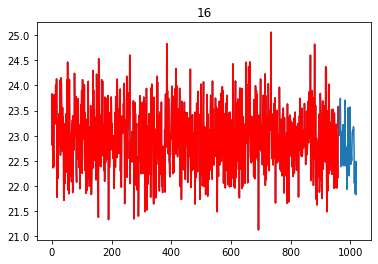

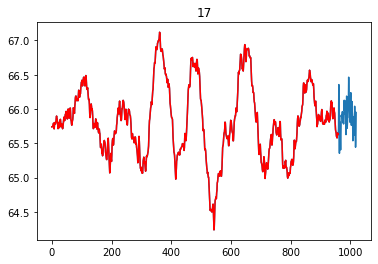

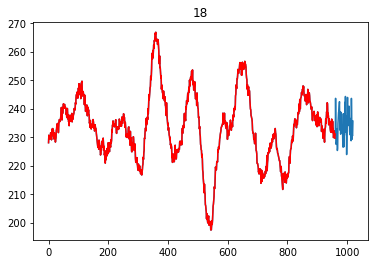

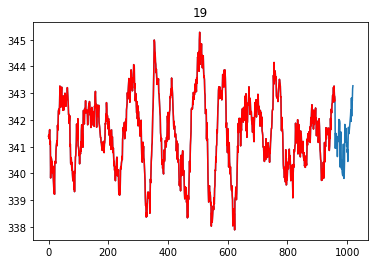

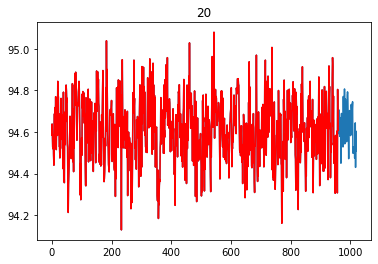

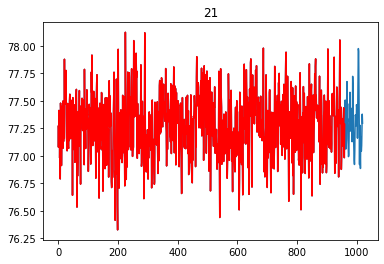

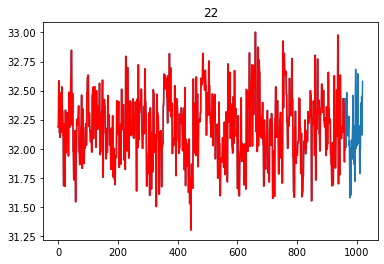

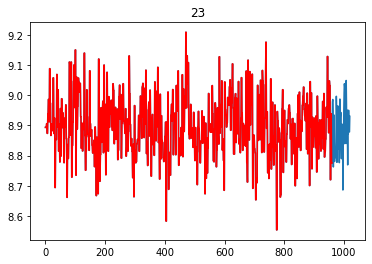

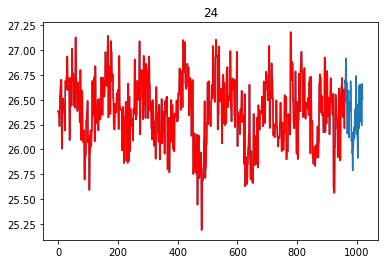

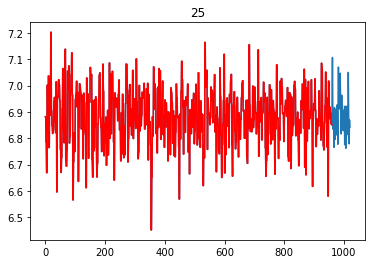

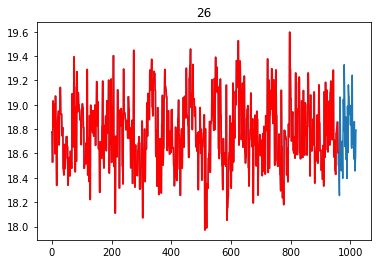

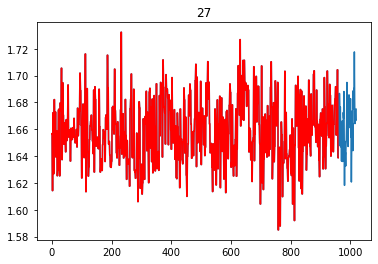

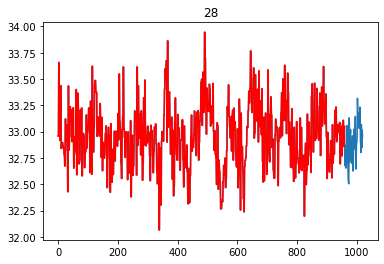

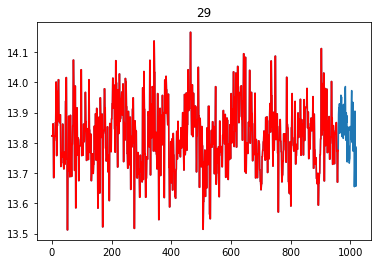

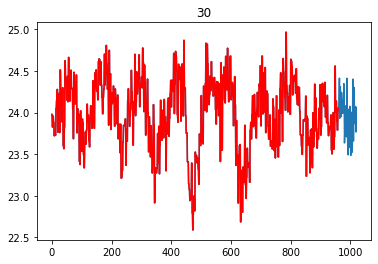

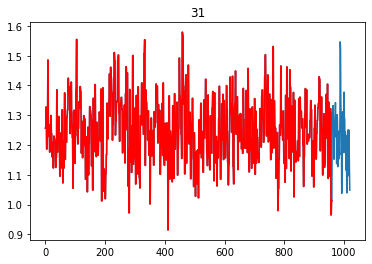

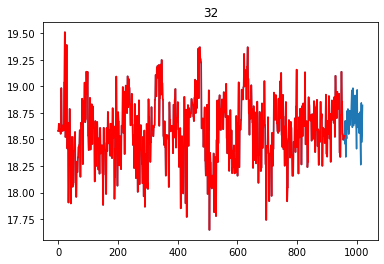

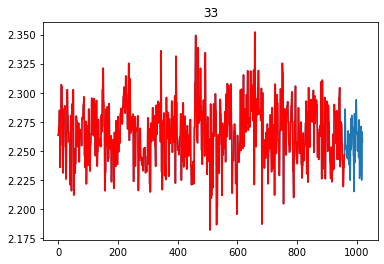

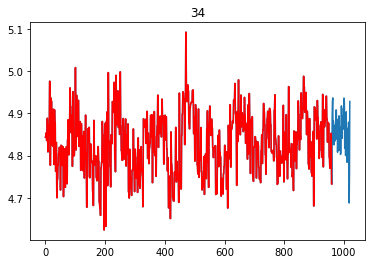

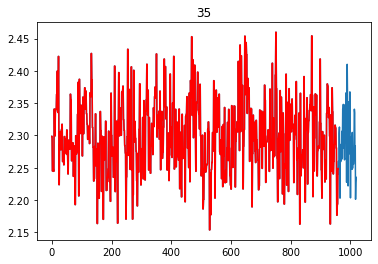

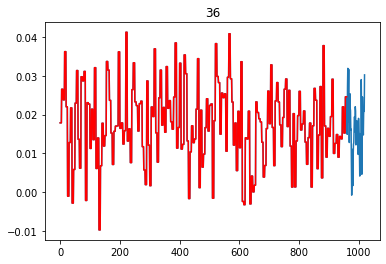

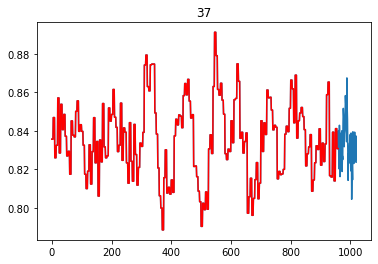

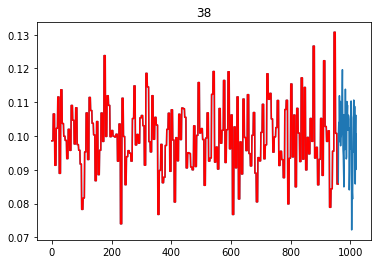

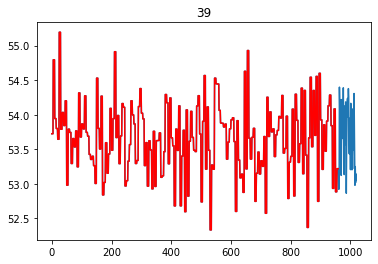

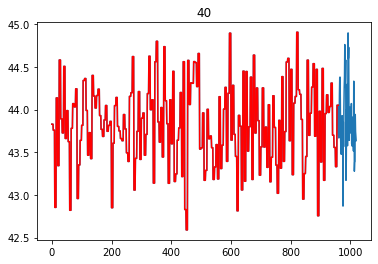

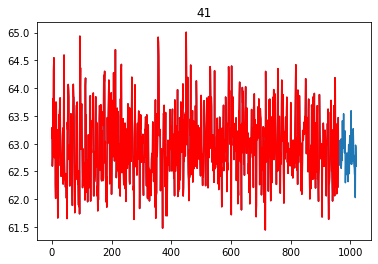

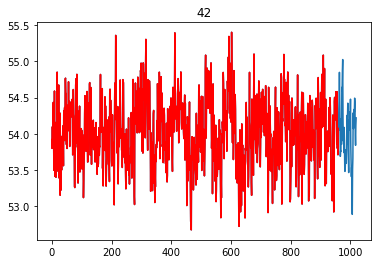

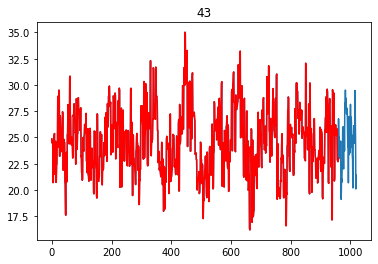

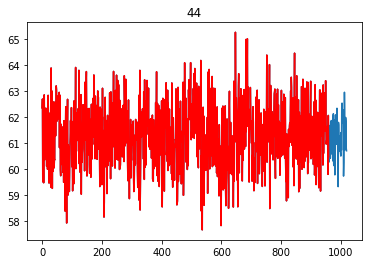

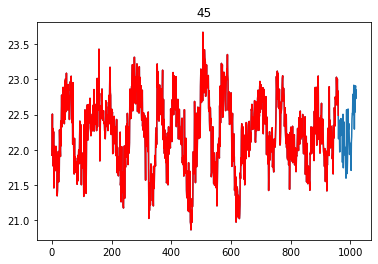

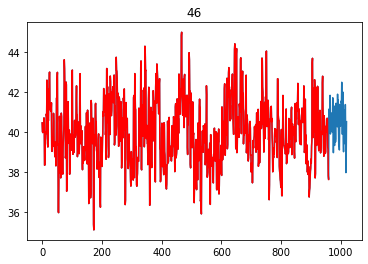

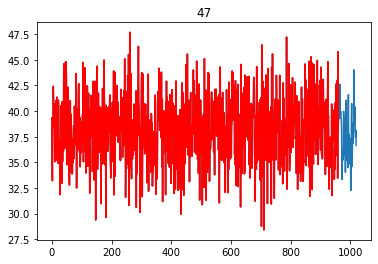

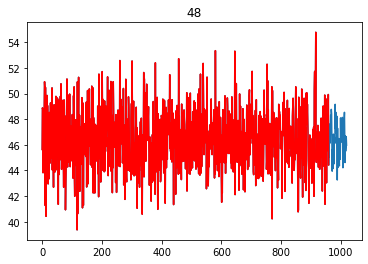

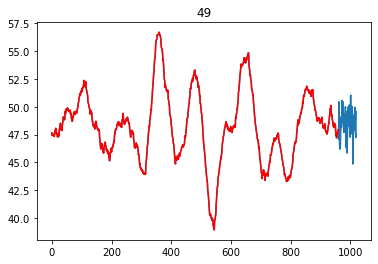

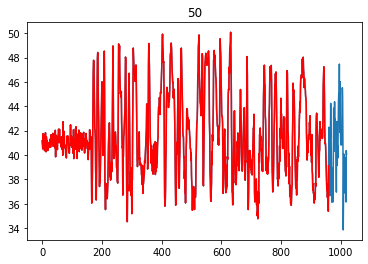

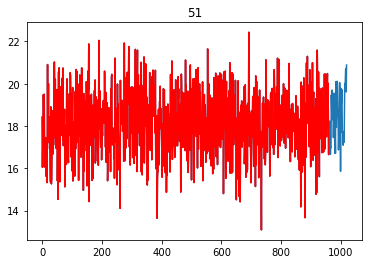

In [40]:
for i in range(tep_data_ori.shape[1]):
    plt.figure(i)  
    plt.title(i)
    all_data = np.concatenate((tep_data_ori[:,i], gen_output[:,i]), axis=0) 
    plt.plot(all_data)
    plt.plot(range(len(tep_data_ori)), tep_data_ori[:,i],'r')


C:\Users\user\AppData\Roaming\Python\Python37\site-packages\ipykernel_launcher.py:2: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  


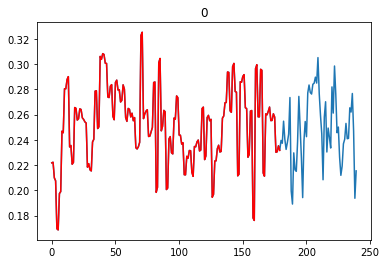

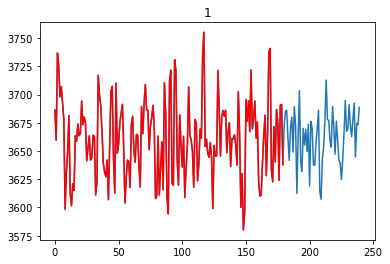

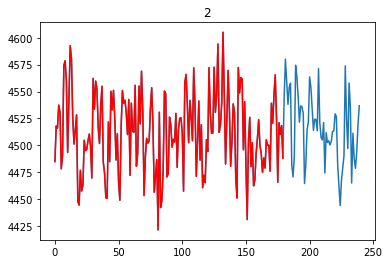

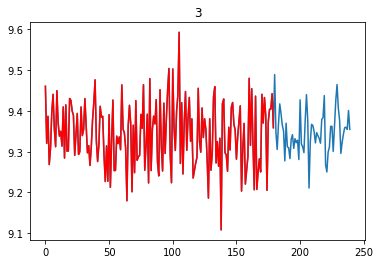

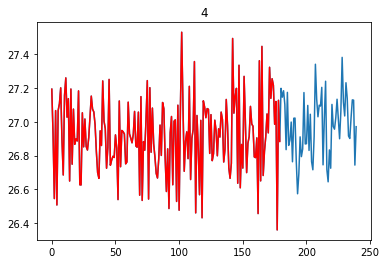

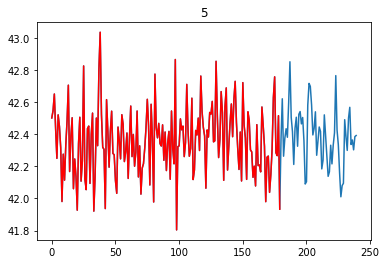

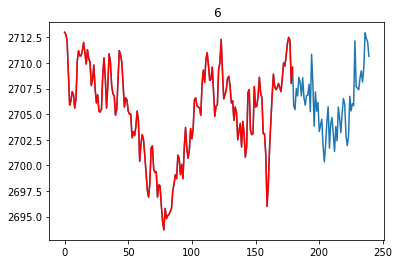

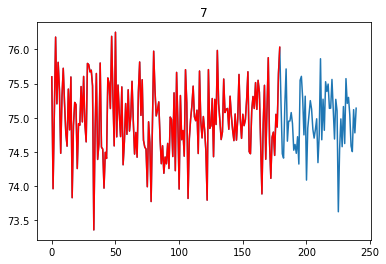

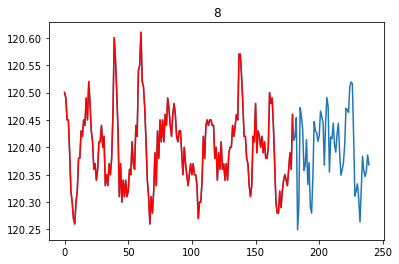

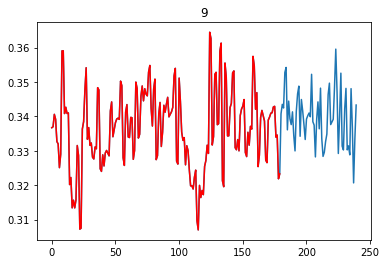

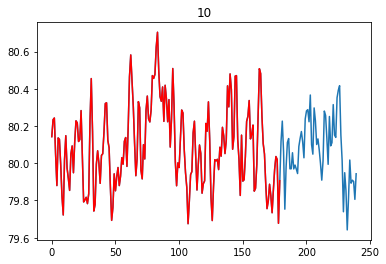

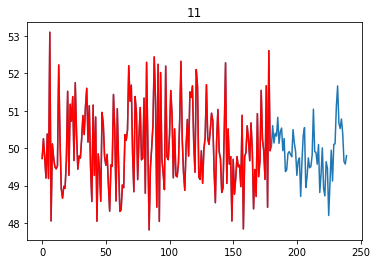

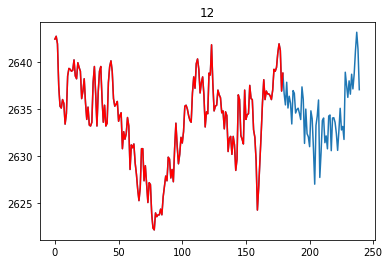

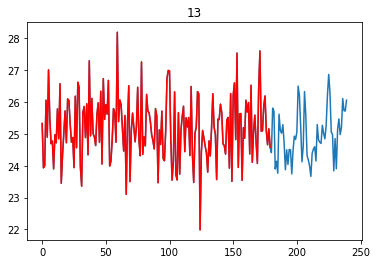

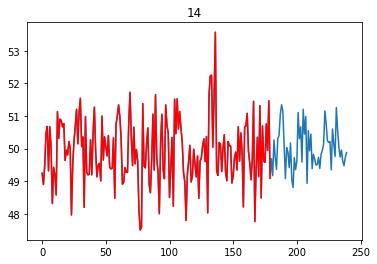

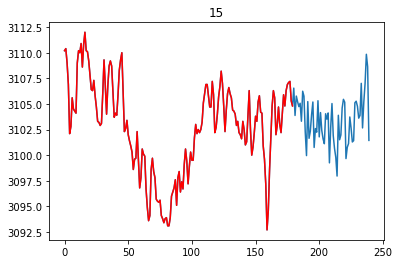

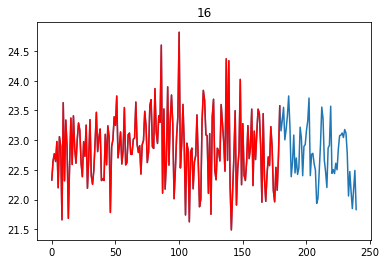

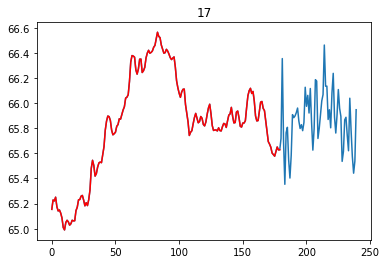

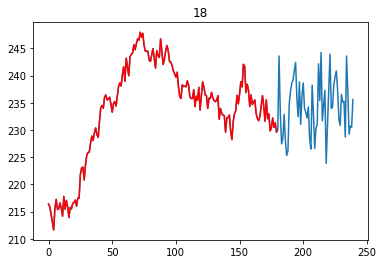

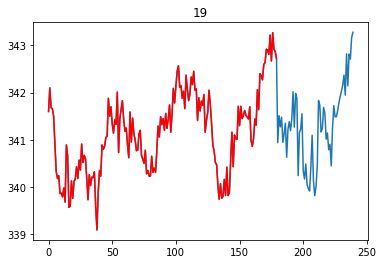

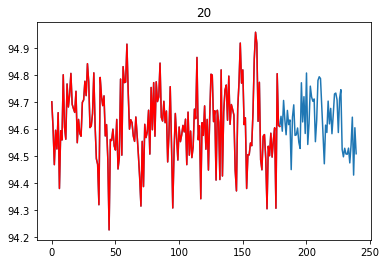

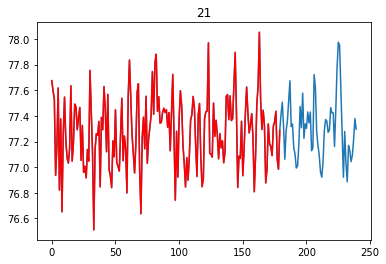

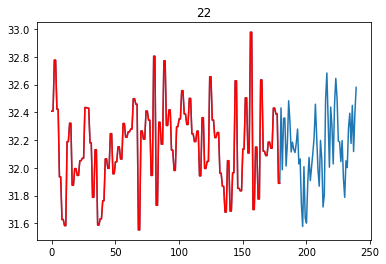

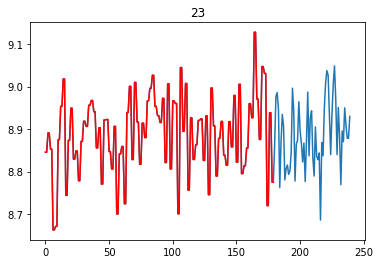

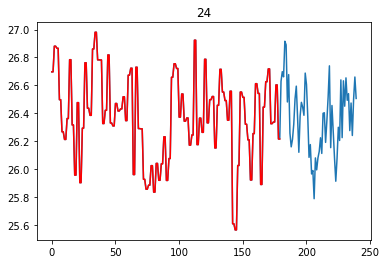

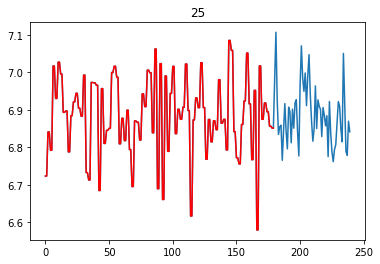

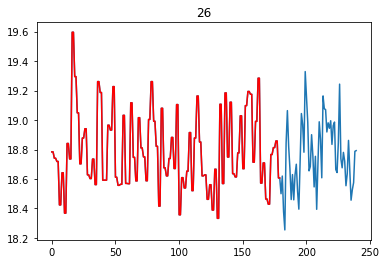

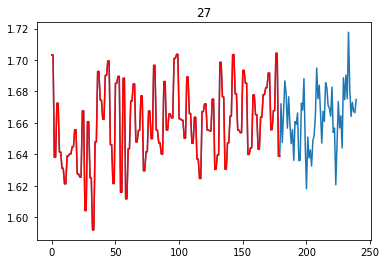

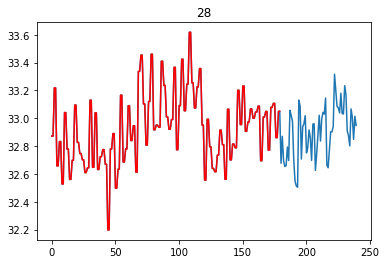

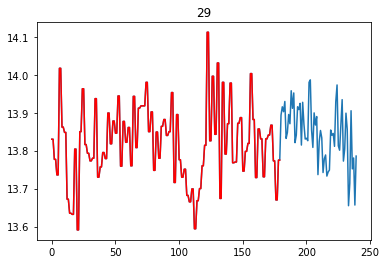

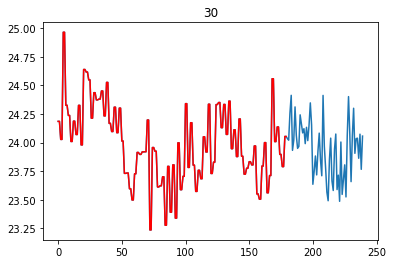

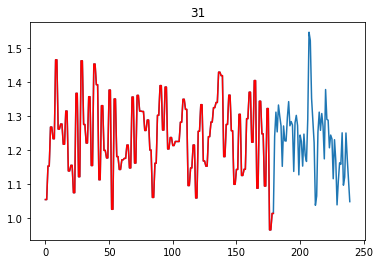

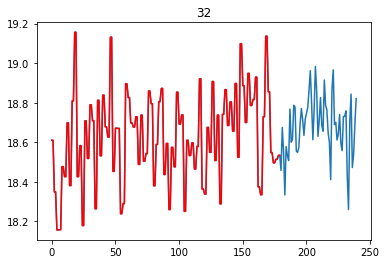

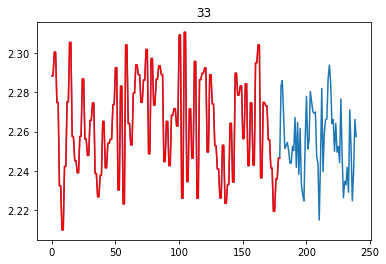

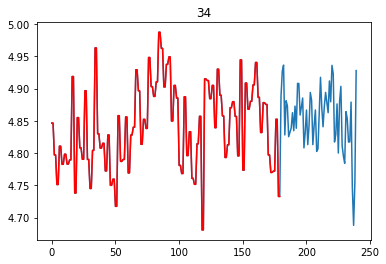

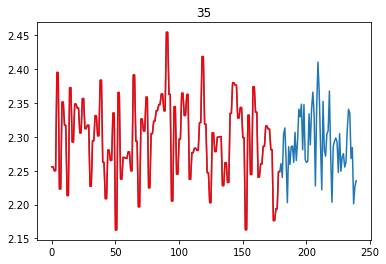

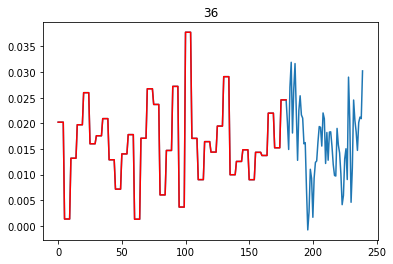

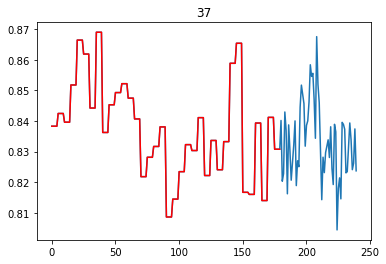

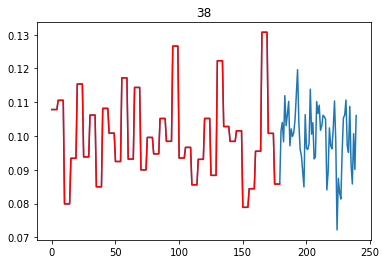

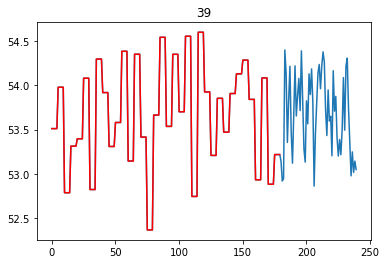

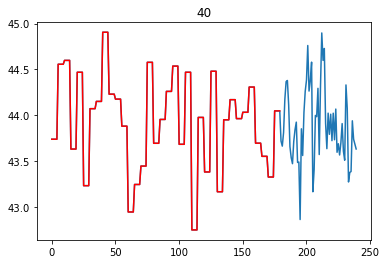

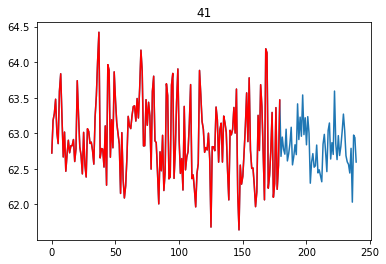

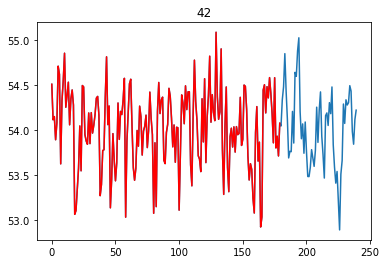

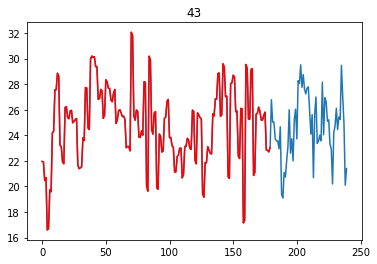

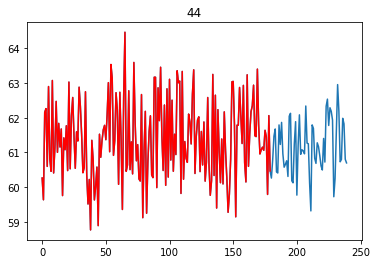

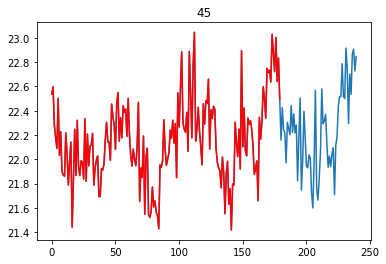

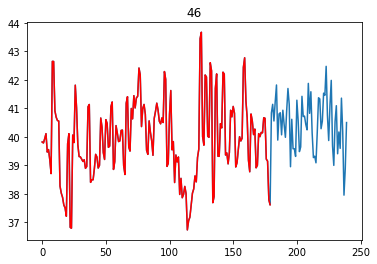

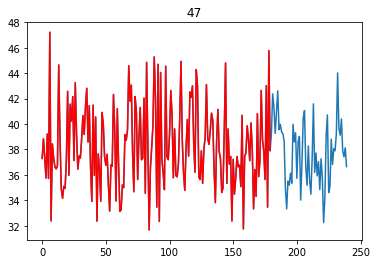

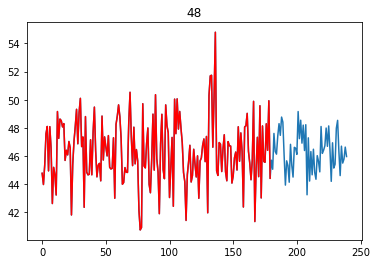

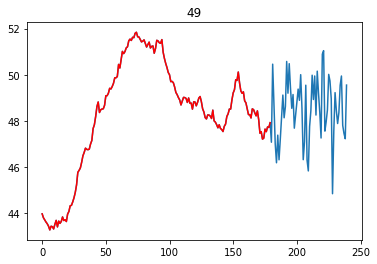

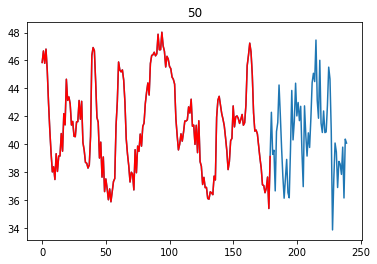

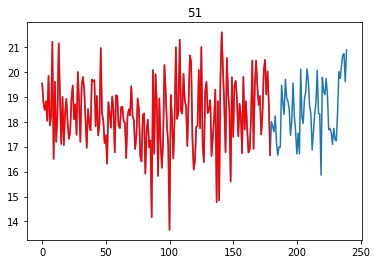

In [41]:
for i in range(tep_data_ori_part.shape[1]):
    plt.figure(i)  
    plt.title(i)
    all_data = np.concatenate((tep_data_ori_part[:,i], gen_output[:,i]), axis=0) 
    plt.plot(all_data)
    plt.plot(range(len(tep_data_ori_part)), tep_data_ori_part[:,i],'r')
